In [1]:
from __future__ import print_function
from __future__ import absolute_import
import warnings
import sys
sys.path.append('../../../../')
sys.path.append('../')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = "viridis"
import random
random.seed(1)
print (tf.__version__)

1.3.0


In [2]:
# data files for train/val. Already preprocessed
data1 = np.load('../data_lim5000_nan.npy.zip')['data_lim5000_nan.npy'].item()
data2 = np.load('../data_lim5000_ss.npy.zip')['data_lim5000_ss'].item()
data3 = np.load('../data_lim5000_extra.npy').item()
data4 = np.load('../data_lim5000_MSA.npy').item()
#  same as above, redundant
data1_t = np.load('../data_lim5000_nan.npy.zip')['data_lim5000_nan.npy'].item()
data2_t = np.load('../data_lim5000_ss.npy.zip')['data_lim5000_ss'].item()
data3_t = np.load('../data_lim5000_extra.npy').item()
data4_t = np.load('../data_lim5000_MSA.npy').item()

In [3]:
# these contains the test sets
puzzle = ['3OX0', '3OWZ', '3OXJ', '3OXE', '3OWZ', '3OWW', '3OXM', '3OWW', '3OWI', '3OXE',
          '3OXM', '3OX0', '3OXJ', '3OWI', '3OXB', '3OXD', '3OXD', '3OXB', '4LCK', '4TZV',
          '4TZZ', '4TZZ', '4TZZ', '4LCK', '4TZZ', '4TZP', '4TZW', '4TZP', '4TZZ', '4TZZ',
          '4TZV', '4TZW', '4TZZ', '4LCK', '4TZZ', '4TZP', '4LCK', '4TZP', '5EAQ', '5DQK',
          '5EAO', '5DH6', '5DI2', '5DH8', '5DH7', '5DI4', '4R4V', '5V3I', '4R4P', '3V7E',
          '3V7E', '4L81', '4OQU', '4P9R', '4P95', '4QLM', '4QLN', '4XWF', '4XW7', '4GXY',
          '5DDO', '5DDO', '5TPY','5T5A','5K7C','5DI4']

In [4]:
data_test = {}
data_train = {}
data_val = {}
thres_distance  = 16

In [5]:
# helper function
def make_array(str): #converts AUGC to vector. 
    temp = [0,]*len(str)
    for i in range(len(str)):
        if str[i]=='A':
            temp[i] = [1,0,0,0,0]
        elif str[i] =='U':
            temp[i] = [0,1,0,0,0]
        elif str[i] =='G':
            temp[i] = [0,0,1,0,0]
        elif str[i] =='C':
            temp[i] = [0,0,0,1,0]
        elif str[i]=='a': #lower caps means less confidence of sequence
            temp[i] = [0.5,0,0,0,0]
        elif str[i] =='u': #lower caps means less confidence of sequence
            temp[i] = [0,0.5,0,0,0]
        elif str[i] =='g': #lower caps means less confidence of sequence
            temp[i] = [0,0,0.5,0,0]
        elif str[i] =='c': #lower caps means less confidence of sequence
            temp[i] = [0,0,0,0.5,0]
        else:
            temp[i] = [0,0,0,0,1]
    return temp
def make_array2(str):
    temp = [0,]*len(str)
    for i in range(len(str)):
        if str[i]=='*':
            temp[i] = 100
        elif str[i] == 'X':
            temp[i] = 0
        else:
            temp[i] = int(str[i])*10
    return temp
def remove_diagonals(d):
    d = d.copy()
    d[0:2,0:2] = 0
    d[-2:,-2:] = 0
    for i in range(2,len(d)-2):
        d[i-1,i] =0
        d[i,i] =0
        d[i,i-1] =0
        d[i-2,i] =0
        d[i,i] =0
        d[i,i-2] =0
        d[i+1,i] =0
        d[i,i] =0
        d[i,i+1] =0
        d[i+2,i] =0
        d[i,i] =0
        d[i,i+2] =0
    return d

In [6]:
random.seed(0)

In [7]:
# making train/val/test index
data1_keys_test = [ x for x in data1_t if x[0:4].upper() in puzzle]    
data1_keys = [x for x in data1 if  len(data1[x][0]) <= 500] # the short ones get val-train split
random.shuffle(data1_keys)
data1_keys_val = ['4v9e_aa', '5lyu_a', '4qjd_b', '4pr6_b', '5fq5_a', '4cxg_a',
                  '5m0h_a', '3amt_b', '4v8m_bd', '5x2h_b', '1e8s_c', '1c9s_w',
                  '2gtt_x', '3j0o_h', '3j45_2', '3j7r_s6', '2nz4_p', '2der_c',
                  '4cxg_2', '3p22_a', '3ivn_a', '3w3s_b', '3j0p_w', '5lzs_ii',
                  '4ug0_s6', '3d2v_a', '2csx_c', '2oiu_q', '4kzd_r', '2j28_8',
                  '5t5h_e', '1ffy_t', '5aka_7', '1pn7_c', '3j46_3', '4ue4_a',
                  '1i6u_c', '3jcs_6', '1j1u_b', '3wc1_p', '3eph_e', '2qwy_a',
                  '1un6_e', '1qzc_a', '4c4q_n', '4v6u_a1', '5xh6_b', '5mmm_z',
                  '2hw8_b', '1mj1_q', '5o60_b', '2zy6_a', '5hr6_c', '4v5z_bg',
                  '2zzm_b', '1p6v_b', '4v5z_ad', '2vpl_b', '1qzw_b', '4c7o_e',
                  '2xxa_f', '2zjr_y', '5kpy_a', '4bbl_y', '1pn8_d', '1lng_b',
                  '1m5o_b', '4kr6_d', '3nkb_b', '1gax_c', '4kr6_c', '2nue_c',
                  '4v8b_ab', '5t83_a', '3p49_a', '3izd_a', '5ktj_a', '3j9w_bb',
                  '3k0j_e', '5gap_v', '3ski_a', '2om7_g', '1ysh_b', '4v8p_b3',
                  '4aob_a', '5lzs_2', '2wwb_d', '3iab_r', '4qjh_b', '4yco_d',
                  '4tue_qv', '4kr7_x', '4adx_8', '2go5_9', '4v8m_be', '1emi_b',
                  '3jb9_c', '5e54_a', '4p5j_a', '1zc8_h', '1y26_x', '1zc8_a',
                  '1hc8_c', '3iyq_a', '5it9_i', '4wj3_q', '3suh_x', '1xjr_a',
                  '4frg_b', '1zn1_c']
data1_keys_train = [x for x in data1_keys if (x not in data1_keys_val and x[0:4].upper() not in puzzle)] +\
                   [x for x in data1 if  len(data1[x][0]) > 500]

In [8]:
# this is to reduce trainset size so you can run faster
#data1_keys_train= data1_keys_train[::10]

In [9]:
# below is abit hairy, preprocessing, optional #
print ('### TRAINSET processing ###')
for i in data1_keys_train:
    if len(data1[i][0]) >= 35:
        if i in data2.keys():
            try:
                temp1 = data1[i]
                a = (data1[i][2] > thres_distance)*1
                temp_resi_map = np.stack((a,),axis=2)
                d0= -1*(np.isnan(data1[i][2])-1) #non-nan values ==1 , nan =0
                d = remove_diagonals(d0)
                d = np.stack((d,) ,axis=2)
                d0= np.stack((d0,),axis=2)
                pair_wise_res = {('A','A') : 0, ('U','U') : 1, ('G','G') : 2, ('C','C') : 3,
                                 ('A','U') : 4, ('A','G') : 5, ('A','C') : 6,
                                 ('G','U') : 7, ('C','U') : 8,
                                 ('C','G') : 9}
                mat_pairres = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((temp1[1][ii],temp1[1][jj]))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres[ii,jj,index] = 1
                            mat_pairres[jj,ii,index] = 1
                mat_pairres_con = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((data4[i][1][ii].upper(),
                                              data4[i][1][jj].upper()))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres_con[ii,jj,index] = 1
                            mat_pairres_con[jj,ii,index] = 1
                data2[i][0] = np.reshape(data2[i][0],(len(data2[i][0]),len(data2[i][0]),1))
                temp2 = data2[i]
                temp2[0] = np.concatenate((data2[i][0],mat_pairres,mat_pairres_con),axis=2)
                temp3 = data3[i]
                temp4 = data4[i]
                tempF = np.concatenate((np.array(make_array(temp1[1])).T,np.array([temp2[1]]),temp3,(np.array(make_array(temp4[1])).T),np.array([make_array2(temp4[2])])))

                if len(temp2[0]) <=500:
                    data_train[i+'_ori'] = [tempF, temp1[0],temp1[1],temp_resi_map,d,temp2[1],temp2[0]]
                for window_tup in [(35,11),(50,13),(75,25),(100,33),(125,41),(150,50),(200,66),(300,100),(400,133),(500,167)]:
                    window, jump = window_tup[0], window_tup[1]
                    for repeat in range(0,len(data1[i][0]) - window+1,jump):
                        if np.mean(d0[repeat:repeat+window,repeat:repeat+window,:]) > 0.9: 
                            data_train[i+'_'+str(window)+'_'+str(repeat)] = [tempF[:,repeat:repeat+window],
                                                   temp1[0][repeat:repeat+window],
                                                   temp1[1][repeat:repeat+window],
                                                   temp_resi_map[repeat:repeat+window,repeat:repeat+window,:],
                                                   d[repeat:repeat+window,repeat:repeat+window,:],
                                                   temp2[1][repeat:repeat+window],
                                                   temp2[0][repeat:repeat+window,repeat:repeat+window]]
                if 2*len(data1[i][0])//3 <= 500:                    
                    window = 2*len(data1[i][0])//3
                    for repeat in (0,1*len(data1[i][0])//6,2*len(data1[i][0])//6):                  
                        data_train[i+'_'+str(window)+'_0.33'] = [tempF[:,repeat:repeat+window],
                                                           temp1[0][repeat:repeat+window],
                                                           temp1[1][repeat:repeat+window],
                                                           temp_resi_map[repeat:repeat+window,repeat:repeat+window,:],
                                                           d[repeat:repeat+window,repeat:repeat+window,:],
                                                           temp2[1][repeat:repeat+window],
                                                           temp2[0][repeat:repeat+window,repeat:repeat+window]]
                if 1*len(data1[i][0])//2 <= 500:
                    window = len(data1[i][0])//2
                    for repeat in (0,1*len(data1[i][0])//4,2*len(data1[i][0])//4):                  
                        data_train[i+'_'+str(window)+'_0.5'] = [tempF[:,repeat:repeat+window],
                                                           temp1[0][repeat:repeat+window],
                                                           temp1[1][repeat:repeat+window],
                                                           temp_resi_map[repeat:repeat+window,repeat:repeat+window,:],
                                                           d[repeat:repeat+window,repeat:repeat+window,:],
                                                           temp2[1][repeat:repeat+window],
                                                           temp2[0][repeat:repeat+window,repeat:repeat+window]]
                if 2*len(data1[i][0])//3 <= 500:
                    window = 3*len(data1[i][0])//4
                    for repeat in (0,1*len(data1[i][0])//8,2*len(data1[i][0])//8):                  
                        data_train[i+'_'+str(window)+'_0.75'] = [tempF[:,repeat:repeat+window],
                                                           temp1[0][repeat:repeat+window],
                                                           temp1[1][repeat:repeat+window],
                                                           temp_resi_map[repeat:repeat+window,repeat:repeat+window,:],
                                                           d[repeat:repeat+window,repeat:repeat+window,:],
                                                           temp2[1][repeat:repeat+window],
                                                           temp2[0][repeat:repeat+window,repeat:repeat+window]]
                        
            except ValueError:
                print ('%s had ValueError, probably some of inputs are of wrong dimention. Data thrown away ' %i)
                print (data2_t[i][0].shape),
print ('### DONE ###\n### VAlidation SET processing ###')
train_n = len(data_train)
for i in data1_keys_val:
    if len(data1[i][0]) >= 35:
        if i in data2.keys():
            try:
                temp1 = data1[i]
                a = (data1[i][2] > thres_distance)*1
                temp_resi_map = np.stack((a,),axis=2)
                d = -1*(np.isnan(data1_t[i][2])-1) #non-nan values ==1 , nan =0
                d = remove_diagonals(d) 
                d = np.stack((d,),axis=2)
                pair_wise_res = {('A','A') : 0, ('U','U') : 1, ('G','G') : 2, ('C','C') : 3,
                                 ('A','U') : 4, ('A','G') : 5, ('A','C') : 6,
                                 ('G','U') : 7, ('C','U') : 8,
                                 ('C','G') : 9}
                mat_pairres = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((temp1[1][ii],temp1[1][jj]))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres[ii,jj,index] = 1
                            mat_pairres[jj,ii,index] = 1
                mat_pairres_con = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((data4[i][1][ii].upper(),
                                              data4[i][1][jj].upper()))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres_con[ii,jj,index] = 1
                            mat_pairres_con[jj,ii,index] = 1
                data2[i][0] = np.reshape(data2[i][0],(len(data2[i][0]),len(data2[i][0]),1))
                temp2 = data2[i]
                temp2[0] = np.concatenate((data2[i][0],mat_pairres,mat_pairres_con),axis=2)                
                temp3 = data3[i]
                temp4 = data4[i]
                tempF = np.concatenate((np.array(make_array(temp1[1])).T,np.array([temp2[1]]),temp3,(np.array(make_array(temp4[1])).T),np.array([make_array2(temp4[2])])))
                    #         [9-features, seq, exxist_seq, cat dist_map,cat dist_map (non-zero), ss_1d, ss_2d]
                data_val[i] = [tempF, temp1[0],temp1[1],temp_resi_map,d,temp2[1],temp2[0]]
            except ValueError:
                print ('%s had ValueError, probably some of inputs are of wrong dimention. Data thrown away ' %i)
print ('### DONE ###')
print ('### BENCHMARKSET processing ###')
print ('benchmark set contains structures which were modelled in competitions, useful for benchmark') 
for i in data1_keys_test:
    if len(data1_t[i][0]) >= 35:
        if i in data2_t.keys():
            try:
                temp1 = data1_t[i]
                a = (data1_t[i][2] > thres_distance)*1
                temp_resi_map = np.stack((a,),axis=2)
                d = -1*(np.isnan(data1_t[i][2])-1) #non-nan values ==1 , nan =0
                d = remove_diagonals(d) 
                d = np.stack((d,),axis=2)
                pair_wise_res = {('A','A') : 0, ('U','U') : 1, ('G','G') : 2, ('C','C') : 3,
                                 ('A','U') : 4, ('A','G') : 5, ('A','C') : 6,
                                 ('G','U') : 7, ('C','U') : 8,
                                 ('C','G') : 9}
                mat_pairres = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((temp1[1][ii],temp1[1][jj]))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres[ii,jj,index] = 1
                            mat_pairres[jj,ii,index] = 1
                mat_pairres_con = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((data4_t[i][1][ii].upper(),
                                              data4_t[i][1][jj].upper()))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres_con[ii,jj,index] = 1
                            mat_pairres_con[jj,ii,index] = 1
                data2_t[i][0] = np.reshape(data2_t[i][0],(len(data2_t[i][0]),len(data2_t[i][0]),1))
                temp2 = data2_t[i]
                temp2[0] = np.concatenate((data2_t[i][0],mat_pairres,mat_pairres_con),axis=2)
                temp3 = data3_t[i]
                temp4 = data4_t[i]
                tempF = np.concatenate((np.array(make_array(temp1[1])).T,np.array([temp2[1]]),temp3,(np.array(make_array(temp4[1])).T),np.array([make_array2(temp4[2])])))
                    #         [9-features, seq, exxist_seq, cat dist_map,cat dist_map (non-zero), ss_1d, ss_2d]
                data_test[i] = [tempF, temp1[0],temp1[1],temp_resi_map,d,temp2[1],temp2[0]]
            except ValueError:
                print ('%s had ValueError, probably some of inputs are of wrong dimention. Data thrown away ' %i)

print ('### DONE ###')             
val_n = len(data_val) 
print ('training samples %s from %s PDBid, val samples %s from %s PDBid' %(train_n,len(data1_keys_train),val_n,len(data1_keys_val)))            
#np.save('data_all.npy',data)
dictt = {}
length = []
for i in data_train.keys():
	if tuple(i.split('_')[0:2]) not in dictt :
		dictt[tuple(i.split('_')[0:2])] = 1
	else :
		dictt[tuple(i.split('_')[0:2])] += 1
	length  += [len(data_train[i][1]),]
#plt.hist([dictt[x] for x in dictt],100);plt.show()
#plt.hist(length,100);plt.show()
# initialzie train data here
data2_x = []
data2_y = []
data2_y_nan = []
data2_y_ss = []
data2_name = []
classweight1 = 0.
classweight2 = 0.
classweight3 = 0.
for i in data_train:
        data2_x += [data_train[i][0],]
        data2_y += [data_train[i][3],]
        data2_y_nan += [data_train[i][-3],]
        data2_y_ss += [data_train[i][-1],]
        data2_name += [i,]
# initialzie val data here
data2_x_val = []
data2_y_val = []
data2_y_nan_val = []
data2_y_ss_val = []
data2_name_val = []       
for i in data_val:
        data2_x_val += [data_val[i][0],]
        data2_y_val += [data_val[i][3],]
        data2_y_nan_val += [data_val[i][-3],]
        data2_y_ss_val += [data_val[i][-1],]
        data2_name_val += [i,]
print (len(data2_y),'finished intitialising total number of training/val samples')
# initialzie test data here
data2_x_test = []
data2_y_test = []
data2_y_nan_test = []
data2_y_ss_test = []
data2_name_test = []       
for i in data_test:
        data2_x_test += [data_test[i][0],]
        data2_y_test += [data_test[i][3],]
        data2_y_nan_test += [data_test[i][-3],]
        data2_y_ss_test += [data_test[i][-1],]
        data2_name_test += [i,]


### TRAINSET processing ###


/home/leexa/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


5tc1_r had ValueError, probably some of inputs are of wrong dimention. Data thrown away 
(9, 9)
### DONE ###
### VAlidation SET processing ###
### DONE ###
### BENCHMARKSET processing ###
benchmark set contains structures which were modelled in competitions, useful for benchmark


/home/leexa/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:140: RuntimeWarning: invalid value encountered in greater


### DONE ###
training samples 6443 from 370 PDBid, val samples 110 from 110 PDBid
6443 finished intitialising total number of training/val samples


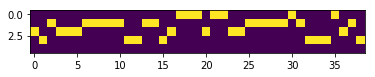

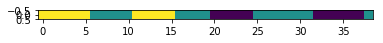

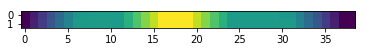

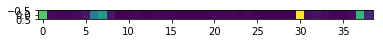

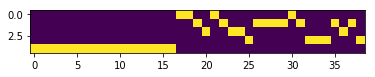

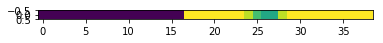

In [116]:
### SEQUENCE FEATURES EXPLORATION ####
### analyze the sequence level features
### X axis - RNA length, Y axis - features, colour = values
RNA_id = 2
plt.imshow (data2_x_val[RNA_id][:5]);plt.show() # sequence AUGC for RNA
plt.imshow (data2_x_val[RNA_id][5:6]);plt.show() # base pairs
plt.imshow (data2_x_val[RNA_id][6:8, ]);plt.show() #positional entropy, base pair probability, mean free energy structre
plt.imshow (data2_x_val[RNA_id][8:9]);plt.show() # base pairs numbering
plt.imshow (data2_x_val[RNA_id][9:-1, ]);plt.show() # sequence AUGC for consenseus sequence
plt.imshow (data2_x_val[RNA_id][-1:, ]);plt.show() # confidence of above prediction


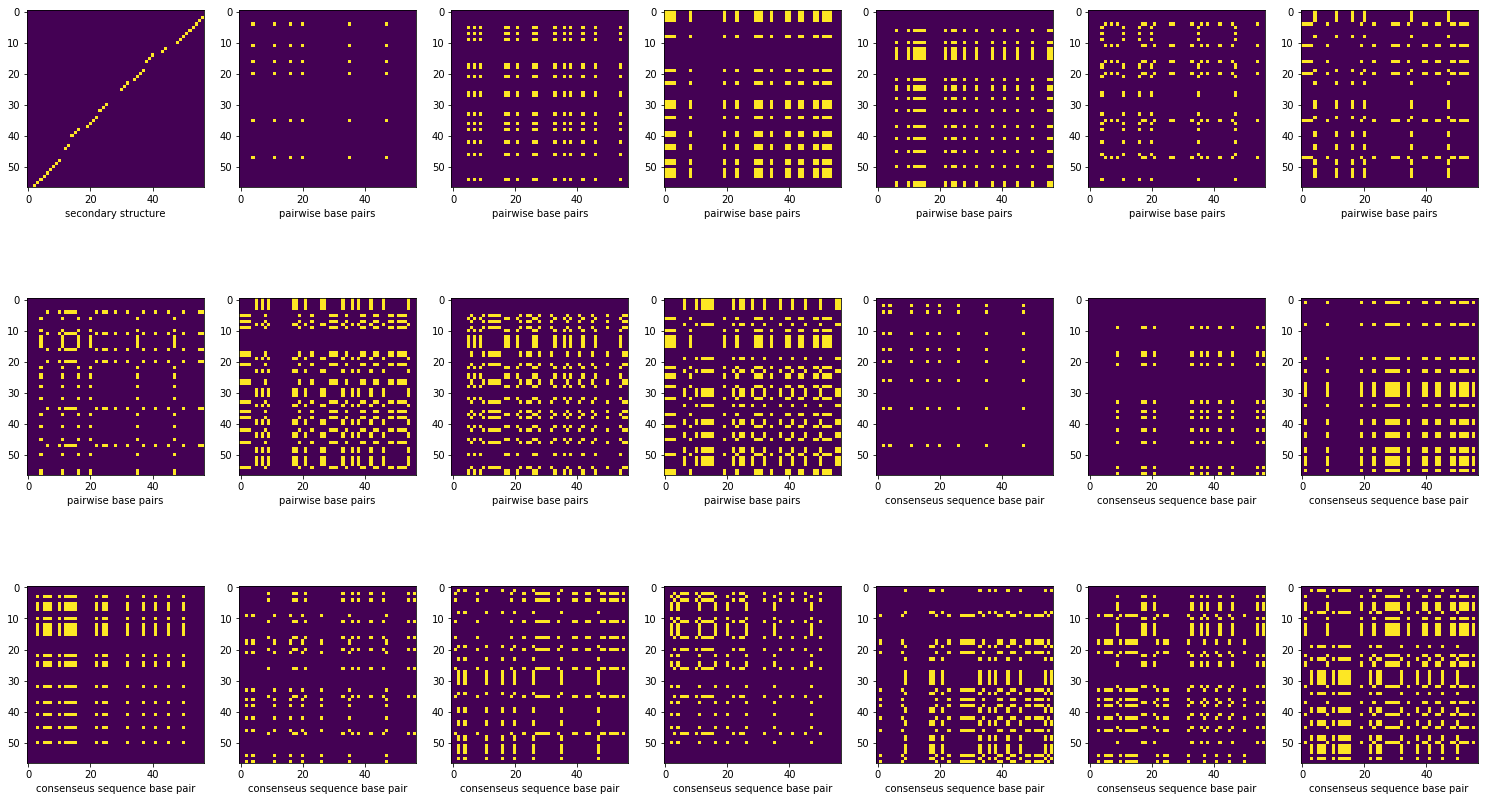

In [61]:
### PAIRWISE FEATURES EXPLORATION ####
### analyze the pairwise seqeunce  features
### X axis - RNA length, Y axis - features, colour = values
RNA_id = 2
f, ax = plt.subplots(3,7,figsize=(26,15));k=0
i=0
ax[i//7,i%7].imshow (data2_y_ss_val[RNA_id][:,:,0]);#plt.show() # secondary structure
ax[i//7,i%7].set_xlabel('secondary structure')
for i in range(1,11):
    ax[i//7,i%7].imshow (data2_y_ss_val[RNA_id][:,:,i]) #pairwise base pairs
    ax[i//7,i%7].set_xlabel('pairwise base pairs')
for i in range(11,21):
    ax[i//7,i%7].imshow (data2_y_ss_val[RNA_id][:,:,i])#consenseus sequence base pair
    ax[i//7,i%7].set_xlabel('consenseus sequence base pair')
plt.show()

In [81]:
## calculate average distances
dist =[]
for x in data1:
    for i in range(len(data1[x][-1])):
        for j in range(i+1,len(data1[x][-1])):
            dist += [data1[x][-1][i,j],]

print (dist[0])

5.829815606


In [86]:
dist[:10]

[5.8298156060033293,
 11.063443406101012,
 16.220957061776591,
 nan,
 24.250906044929536,
 26.339016876109859,
 26.958305380717089,
 27.59078864403843,
 30.083552200496534,
 34.237848253066367]

# the histogram shows peaks at ~8,12,18 using some guestimation of combined gaussians. This is why i used a cutoff of 16 for the class seperation. This is because 16 seems like the first peak.

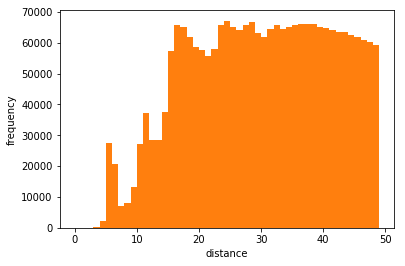

In [103]:
# the histogram of distances
plt.hist([x for x in dist if x > 0]  ,bins = range(50));
plt.xlabel('distance')
plt.ylabel('frequency')
plt.show()


# finding number of nan in distances. Distances might not be measured due to failure of experimental methods to obtain complete data

/home/leexa/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal


average of 0.0591272240682 distances are missing, std = 0.140476183928, max= 0.995116561207


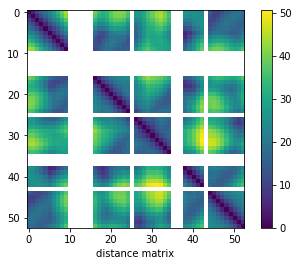

/home/leexa/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal


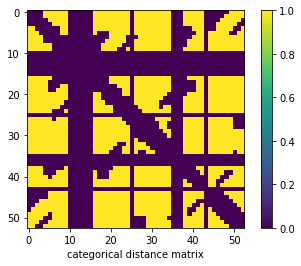

In [129]:
# the histogram of distances
per_nan = []
for x in data1:
    per_nan  += [1- np.mean(data1[x][-1] >= 0),]
print ('average of %s distances are missing, std = %s, max= %s' 
       %(np.mean(per_nan),np.std(per_nan),np.max(per_nan)))

## missing resdues shown as white bars where distance inforamtion is missing

plt.imshow(data1[data1.keys()[2]][-1]);
plt.xlabel('distance matrix');plt.colorbar();plt.show() 
plt.imshow(data1[data1.keys()[2]][-1] >= 16);
plt.xlabel('categorical distance matrix');plt.colorbar();plt.show() 

# I will maks out the missing values and the diagonals to the loss function. The diagonals are masked since they are easy to predict (always 0). Missing pixels should not be included into loss or else it will learn to predict them as 0.

/home/leexa/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


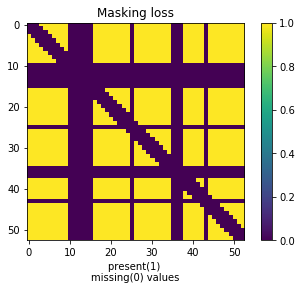

In [115]:
plt.imshow(remove_diagonals(data1[data1.keys()[2]][-1] >= 0.0));
plt.title('Masking loss')
plt.xlabel('present(1) \nmissing(0) values');plt.colorbar();plt.show() 